## Key findings and achievements

> * 
> * 

---

## Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

Our dataset is composed by two-year sales data from an online store based in the UK. We first import the data and provide a glimpse of it.

In [2]:
df = pd.read_parquet('../../data/concatenated_online_retail_II.parquet')

df = df.rename(columns={'Customer ID': 'CustomerID'})
df = df.dropna(subset='CustomerID', axis=0)

df['CustomerSince'] = df.groupby('CustomerID')[['InvoiceDate']].transform(min)
df['Lifespan'] =  df['InvoiceDate'] - df['CustomerSince']
df['Lifespan_M'] = (df['Lifespan'].dt.days / 30.44).astype(int)
df['MonthlyCohort'] = pd.to_datetime(df['CustomerSince']).dt.to_period('M') #.dt.to_timestamp()
df['Amount'] = df['Price'] * df['Quantity']

# Mapping regions
regions = {'Europe': ['Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland', 'Netherlands', 'Belgium', 'France', 'Germany', 'Switzerland', 'Austria',
                      'Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Czech Republic', 'Lithuania', 'Poland', 'United Kingdom', 'EIRE',
                      'Channel Islands', 'European Community'],
           'North America': ['USA', 'Canada'],
           'Middle East': ['Bahrain', 'United Arab Emirates', 'Israel', 'Lebanon', 'Saudi Arabia'],
           'Asia Pacific': ['Japan', 'Australia', 'Singapore', 'Hong Kong', 'Korea', 'Thailand'],
           'RoW': ['Brazil', 'RSA', 'West Indies', 'Nigeria', 'Bermuda'],
           'Unspecified': ['Unspecified']}

country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

df['Region'] = df['Country'].map(country_to_region)

df = df[df['Amount'] > 0]

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Year,CustomerSince,Lifespan,Lifespan_M,MonthlyCohort,Amount,Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,83.4,Europe
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,81.0,Europe
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,81.0,Europe
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,100.8,Europe
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,2009-12,30.0,Europe


## Monthly Cohorts

In [3]:
grouped_m = df.groupby(['MonthlyCohort', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalRevenue=('Amount', 'sum')).reset_index()
grouped_m

,MonthlyCohort,Lifespan_M,n,TotalRevenue
0,2009-12,0,32111,730976.720
1,2009-12,1,13433,403375.071
2,2009-12,2,13449,353813.642
3,2009-12,3,13279,352853.150
4,2009-12,4,14197,337613.590
...,...,...,...,...
314,2011-10,1,2107,26349.110
315,2011-10,2,69,737.210
316,2011-11,0,7014,89903.810
317,2011-11,1,89,4225.350


### Retention

Implementing a cohort analysis is useful for a business to evaluate clients' retention over time. The most common practice is to divide customers according to the period in which they were first acquired (Monthly Cohorts). Based on the available data, we can also divide them by Region.

In [4]:
df.groupby('CustomerID')[['Lifespan_M']].count()

,Lifespan_M
CustomerID,
12346.0,34
12347.0,253
12348.0,51
12349.0,175
12350.0,17
...,...
18283.0,986
18284.0,28
18285.0,12


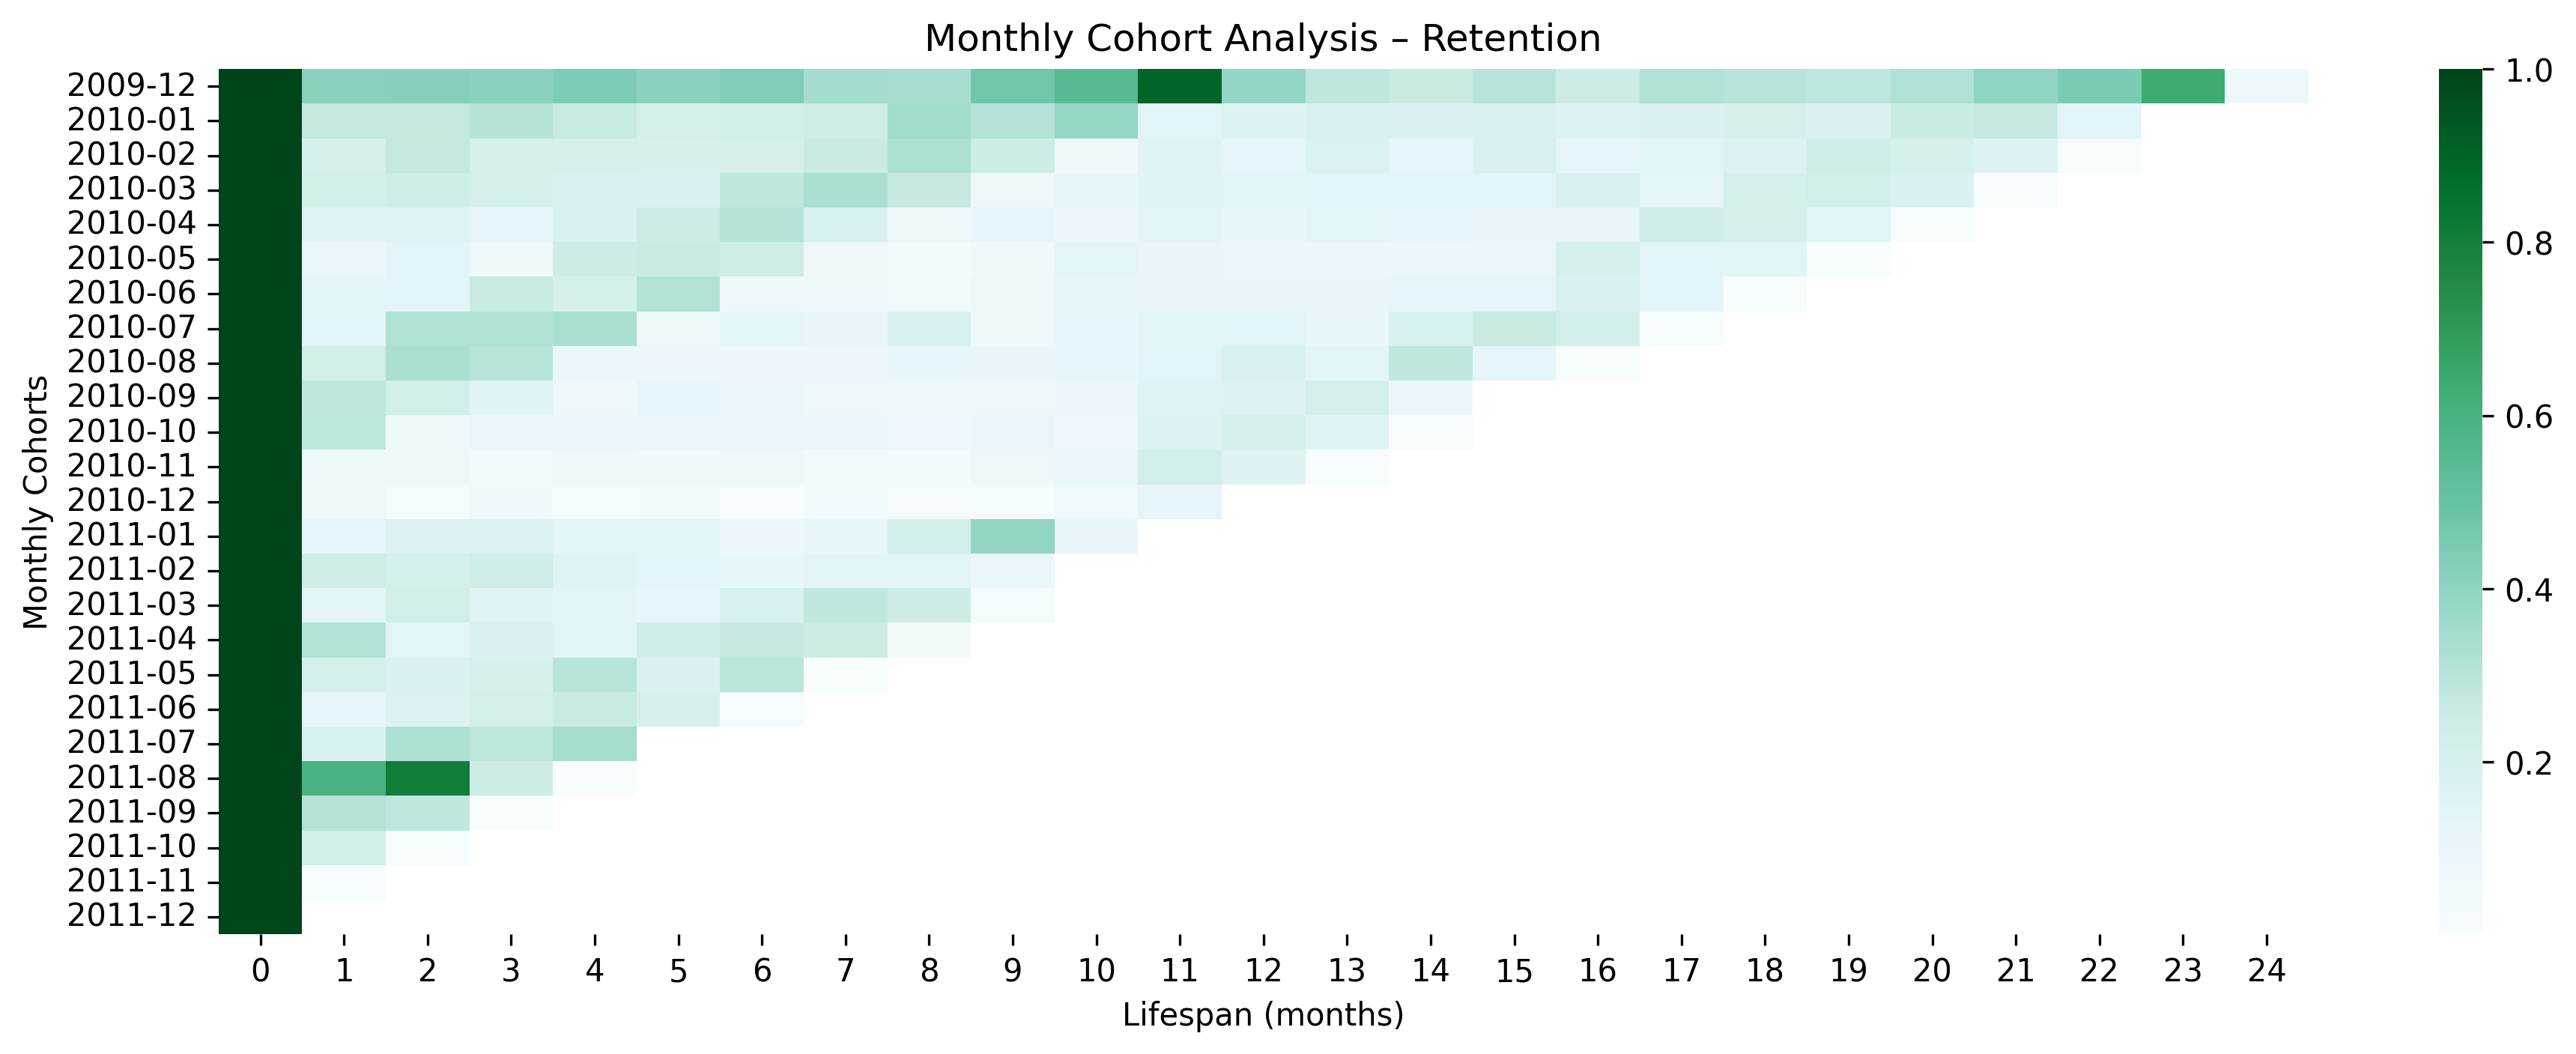

In [5]:
cohorts = grouped_m.reset_index(drop=True).pivot(index='MonthlyCohort', columns='Lifespan_M', values='n')
retention = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(retention, cmap='BuGn')
plt.title("Monthly Cohort Analysis – Retention")
plt.xlabel('Lifespan (months)')
plt.ylabel('Monthly Cohorts')
plt.show()

#### Aggregate

In an aggregate manner, we can then calculate the average retention rate per lifespan period, to get a general idea of how retention is expected during the lifespan of a client.

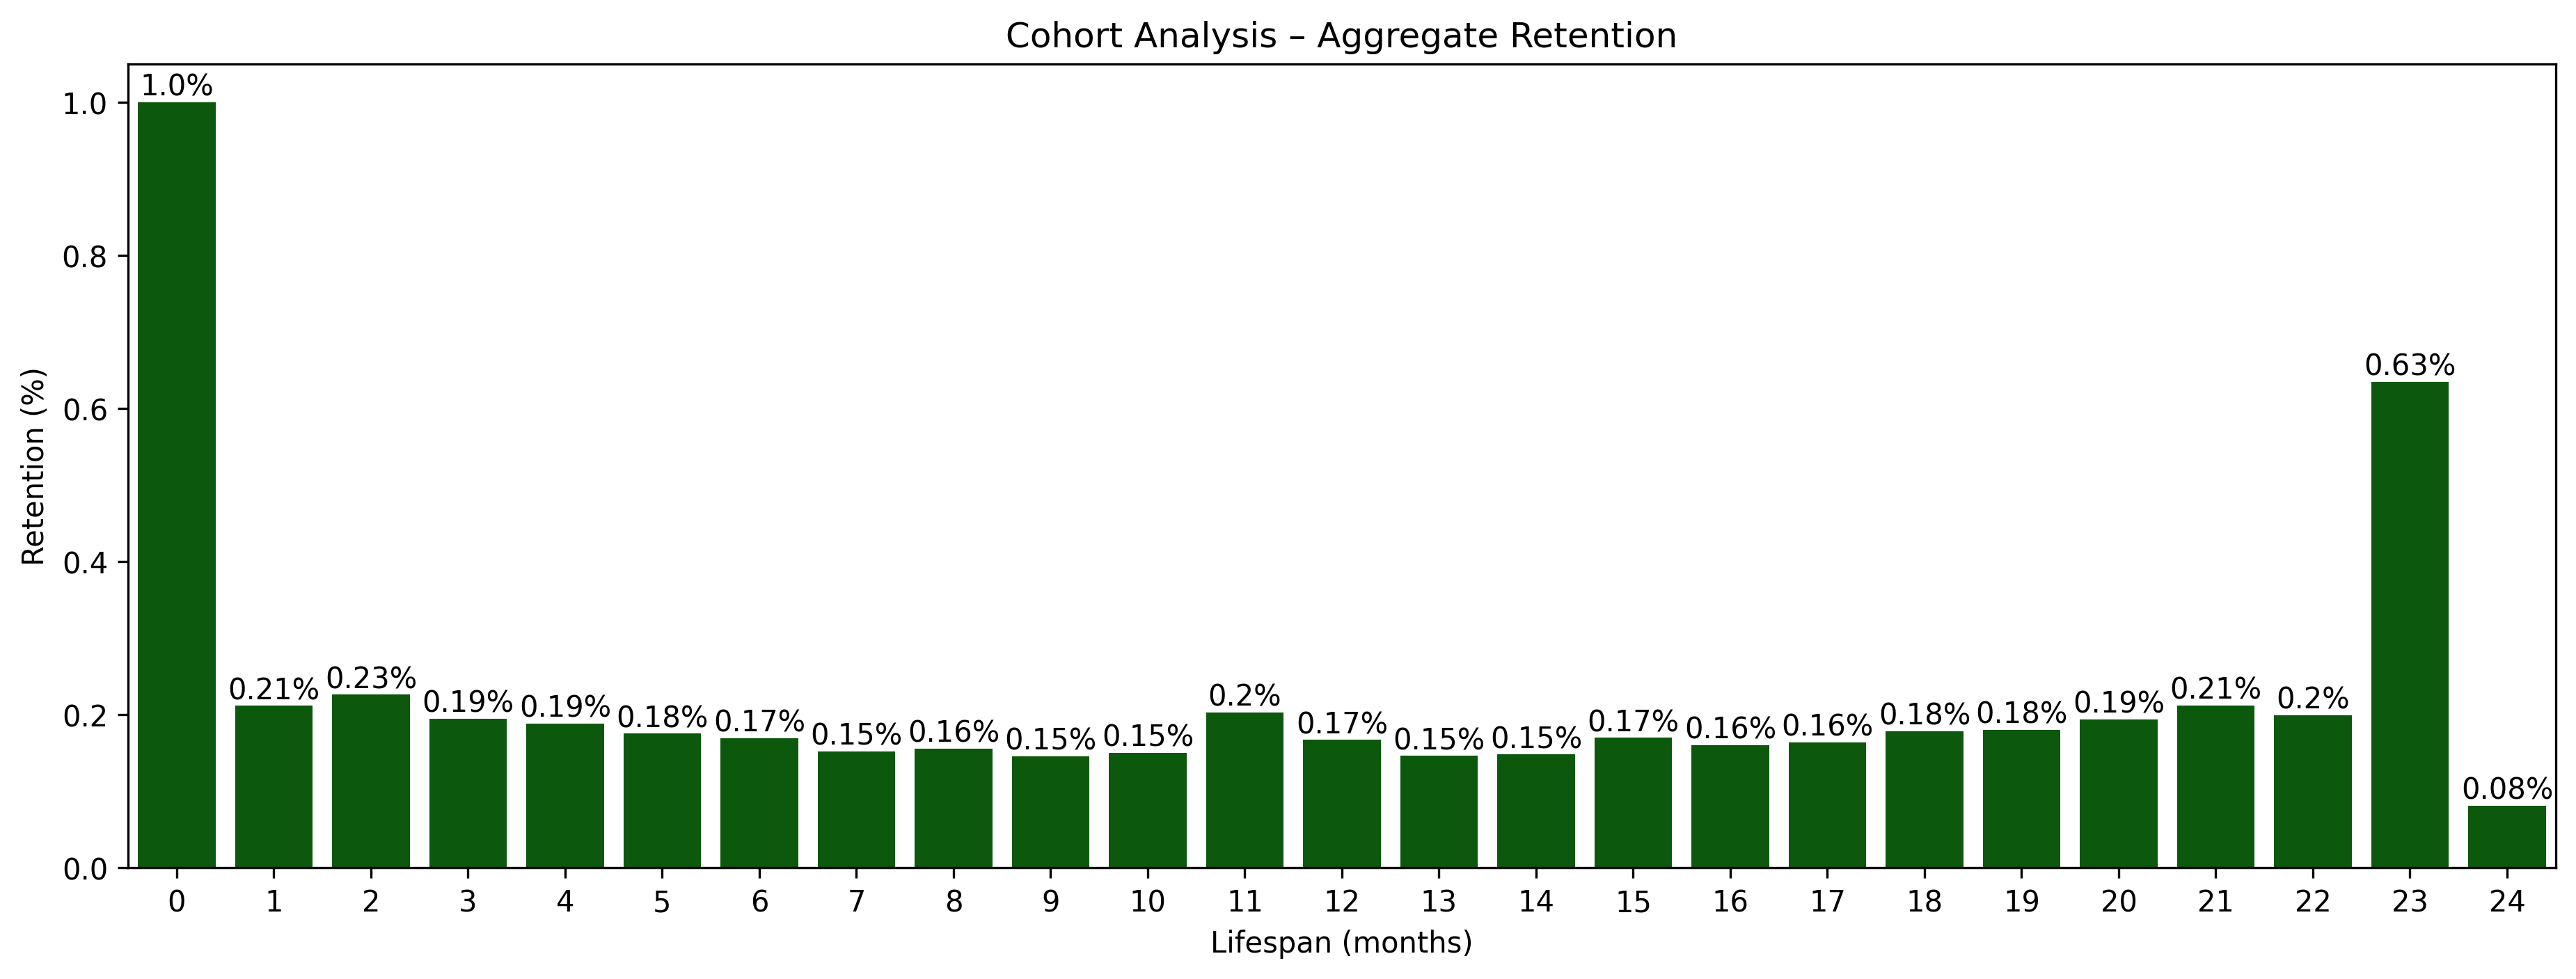

In [6]:
retention_agg = pd.DataFrame(retention.mean()).reset_index()

plt.figure(figsize=(15, 5), dpi=300)
ax = sns.barplot(retention_agg, x='Lifespan_M', y=0, color='darkgreen')

for p in ax.patches:
    count = p.get_height().round(2)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 0.02
    ax.annotate(f'{count}%', (x, y), ha='center', va='center')

plt.title("Cohort Analysis – Aggregate Retention")
plt.ylabel('Retention (%)')
plt.xlabel('Lifespan (months)')
plt.show()

### Revenue

The same principle could be applied to revenue and average purchase value.

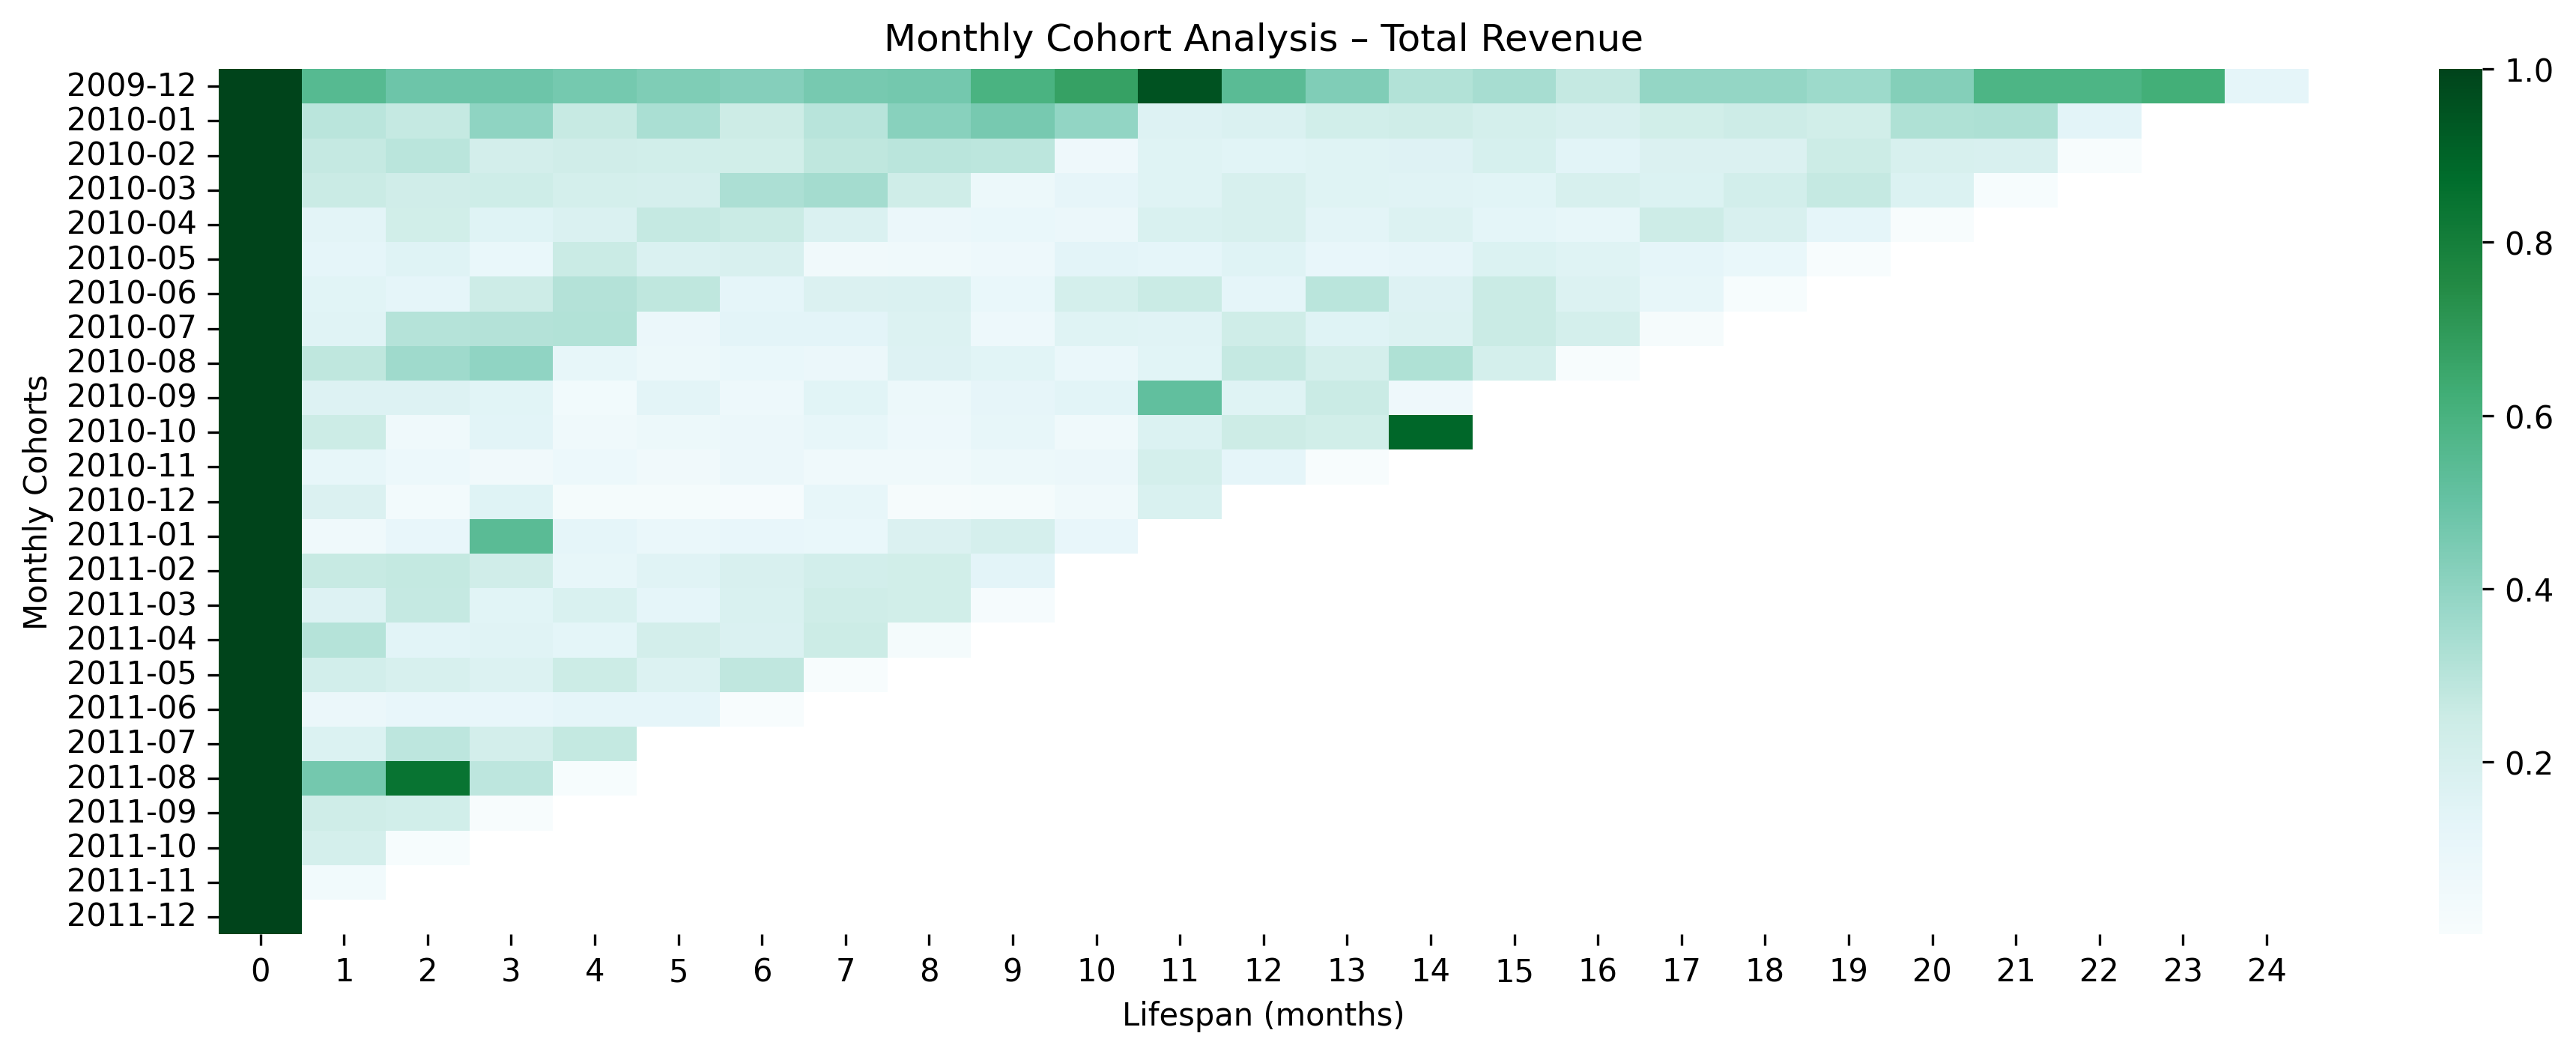

In [7]:
cohorts = grouped_m.reset_index(drop=True).pivot(index='MonthlyCohort', columns='Lifespan_M', values='TotalRevenue')
retention = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(retention, cmap='BuGn')
plt.title("Monthly Cohort Analysis – Total Revenue")
plt.xlabel('Lifespan (months)')
plt.ylabel('Monthly Cohorts')
plt.show()

## Regional Cohorts

In [8]:
grouped_r = df.groupby(['Region', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalRevenue=('Amount', 'sum')).reset_index()
grouped_r

,Region,Lifespan_M,n,TotalRevenue
0,Asia Pacific,0,606,17983.78
1,Asia Pacific,1,120,7324.13
2,Asia Pacific,2,54,3396.66
3,Asia Pacific,3,103,5327.51
4,Asia Pacific,4,236,21895.21
...,...,...,...,...
64,Unspecified,4,41,843.55
65,Unspecified,5,68,2379.88
66,Unspecified,7,76,1387.50
67,Unspecified,15,62,1104.73
